# Initial script to obtain Pancreas dataset from CellRank for Simulation Experiment 2
### by Emma Dann

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
sys.path.append('../source') 
import warnings
warnings.filterwarnings("ignore")

In [23]:
import anndata
import scanpy as sc
import pandas as pd
import cellrank as cr
from cellrank.datasets import pancreas_preprocessed

## Test on pancreas dataset

In [3]:
# pip install git+https://github.com/theislab/cellrank

In [5]:
adata = pancreas_preprocessed()
adata.obs['time'] = adata.obs['dpt_pseudotime'].copy()
adata.X = adata.X.toarray()

Get beta lineage drivers using Cellrank

In [6]:
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

k = 0.8 * vk + 0.2 * ck
g = cr.estimators.GPCCA(k)

g.compute_schur(n_components=4)
g.compute_macrostates(cluster_key="clusters")
g.set_terminal_states_from_macrostates(["Alpha", "Beta", "Epsilon"])
g.compute_absorption_probabilities()

beta_drivers = g.compute_lineage_drivers(lineages="Beta")

  0%|          | 0/2531 [00:00<?, ?cell/s]

  0%|          | 0/2531 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


  0%|          | 0/3 [00:00<?, ?/s]

In [7]:
# keep only differentiation 2 beta lineage
adata = adata[adata.obs['clusters'].isin(['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta'])].copy()

/home/jovyan/my-conda-envs/genes2genes-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


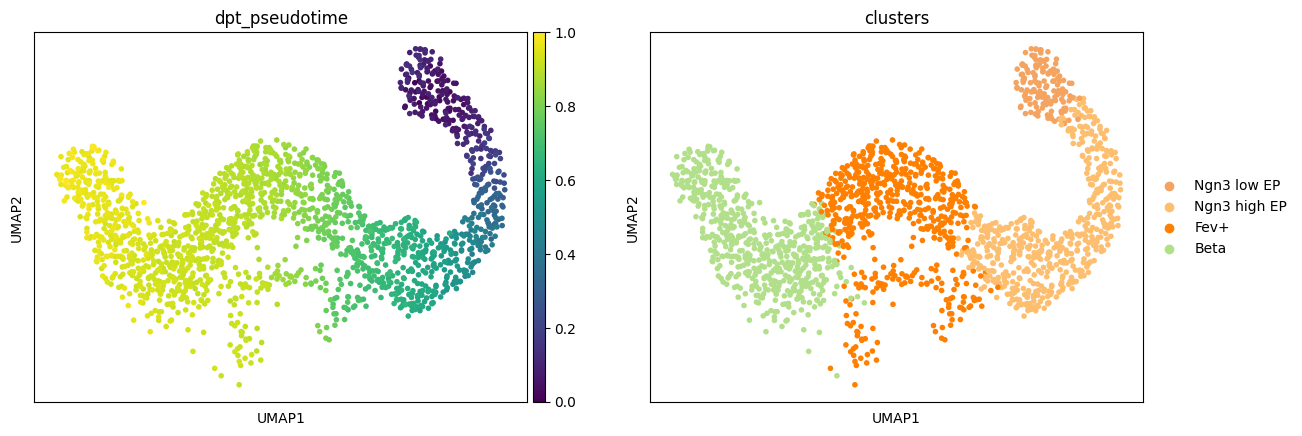

In [8]:
sc.pl.umap(adata, color=['dpt_pseudotime', 'clusters'])

In [77]:
adata.var = pd.concat([adata.var, beta_drivers], axis=1)

In [79]:
adata.var['simulation_gene'] = beta_drivers['Beta_qval'] < 0.01

In [80]:
## Save object
adata.write_h5ad('./data/match_accuracy_pancreas.h5ad')

In [24]:
adata = sc.read_h5ad('./data/match_accuracy_pancreas.h5ad')